In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime
from math import ceil

# IT'S ONLY VALID FOR SERVERLESS V4 DATA
start = datetime(2022, 12, 27, 8, 44)
test_duration = np.timedelta64(8, 'h')

def to_delta(df, column):
    # start = df[column].min()
    print(start)
    df[column] = df[column].apply(lambda dt: dt - start)
    df.set_index(column, inplace=True, drop=False)

def load_cloudwatch(filename):
    logs = pd.read_csv(filename)
    logs = logs.sort_values(by='timestamp')
    logs['timestamp'] = pd.to_datetime(logs['timestamp'])
    logs = logs[logs['timestamp'] > start]
    to_delta(logs, 'timestamp')
    return logs

def start_plot():
    fig, ax = plt.subplots()
    ax.set_xlabel("Czas trwania testu [h]")

    return (fig, ax)

def human_delta(index):
    return index.get_level_values('timestamp').seconds / 60 / 60

In [3]:
prefix = 'serverless_v4_raw_data/'
filename = f"{prefix}/logs.csv"

logs = load_cloudwatch(filename)
logs['billedDuration'] = logs['duration'].apply(lambda d: ceil(d))
logs

2022-12-27 08:44:00


,timestamp,duration,maxMemoryUsed,memorySize,initDuration,billedDuration
timestamp,,,,,,
0 days 00:00:34.491000,0 days 00:00:34.491000,8702.57,348000000.0,1.024000e+09,6144.72,8703
0 days 00:00:34.771000,0 days 00:00:34.771000,220.87,350000000.0,1.024000e+09,NaN,221
0 days 00:00:35.309000,0 days 00:00:35.309000,476.74,353000000.0,1.024000e+09,NaN,477
0 days 00:00:35.986000,0 days 00:00:35.986000,33.40,353000000.0,1.024000e+09,NaN,34
0 days 00:00:36.666000,0 days 00:00:36.666000,70.71,353000000.0,1.024000e+09,NaN,71
...,...,...,...,...,...,...
0 days 08:02:02.232000,0 days 08:02:02.232000,32.58,340000000.0,1.024000e+09,NaN,33
0 days 08:04:49.376000,0 days 08:04:49.376000,43.27,340000000.0,1.024000e+09,NaN,44
0 days 08:04:54.438000,0 days 08:04:54.438000,13.60,340000000.0,1.024000e+09,NaN,14


In [4]:
# Number of coldstarts across the whole load
logs[logs.initDuration > 0].count()

timestamp         17
duration          17
maxMemoryUsed     17
memorySize        17
initDuration      17
billedDuration    17
dtype: int64

In [5]:
invocations = load_cloudwatch(f"{prefix}/invocations.csv")
invocations

2022-12-27 08:44:00


,timestamp,invocations
timestamp,,
0 days 00:01:00,0 days 00:01:00,98.0
0 days 00:02:00,0 days 00:02:00,101.0
0 days 00:03:00,0 days 00:03:00,103.0
0 days 00:04:00,0 days 00:04:00,101.0
0 days 00:05:00,0 days 00:05:00,102.0
...,...,...
0 days 08:01:00,0 days 08:01:00,2.0
0 days 08:02:00,0 days 08:02:00,1.0
0 days 08:03:00,0 days 08:03:00,NaN


In [6]:
concurrent = load_cloudwatch(f"{prefix}/concurrent-executions.csv")
concurrent


2022-12-27 08:44:00


,timestamp,concurrentExecutions
timestamp,,
0 days 00:01:00,0 days 00:01:00,1.0
0 days 00:02:00,0 days 00:02:00,1.0
0 days 00:03:00,0 days 00:03:00,1.0
0 days 00:04:00,0 days 00:04:00,1.0
0 days 00:05:00,0 days 00:05:00,1.0
...,...,...
0 days 08:01:00,0 days 08:01:00,1.0
0 days 08:02:00,0 days 08:02:00,1.0
0 days 08:03:00,0 days 08:03:00,NaN


In [7]:
cold_starts = logs[logs['initDuration'] > 0].resample('10T').count()

resampled_concurrent = concurrent.resample('10T').sum(numeric_only=True)
resampled_invocations = invocations.resample('10T').sum(numeric_only=True)

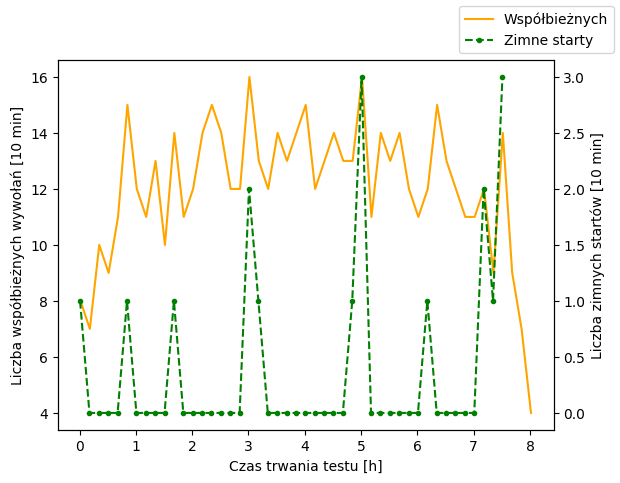

In [8]:
fig, ax = start_plot()
# ax.plot(human_delta(resampled_invocations.index), resampled_invocations['invocations'], label="Łącznie")
ax.plot(human_delta(resampled_concurrent.index), resampled_concurrent['concurrentExecutions'], label="Współbieżnych", color='orange')
ax.set_ylabel("Liczba współbieżnych wywołań [10 min]")

ax2 = ax.twinx()
ax2.plot(human_delta(cold_starts.index), cold_starts['duration'], color='green', marker='.', linestyle='--', label='Zimne starty')
ax2.set_ylabel("Liczba zimnych startów [10 min]")
fig.legend()

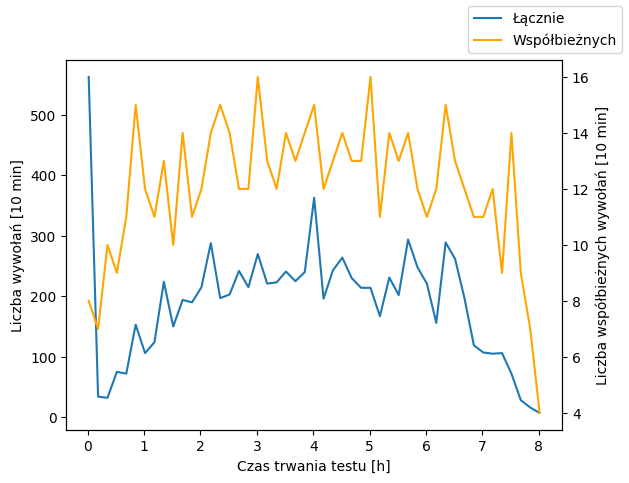

In [9]:
fig, ax = start_plot()
ax.plot(human_delta(resampled_invocations.index), resampled_invocations['invocations'], label="Łącznie")
ax.set_ylabel("Liczba wywołań [10 min]")

ax2 = ax.twinx()
ax2.plot(human_delta(resampled_concurrent.index), resampled_concurrent['concurrentExecutions'], label="Współbieżnych", color='orange')
ax2.set_ylabel("Liczba współbieżnych wywołań [10 min]")
fig.legend()

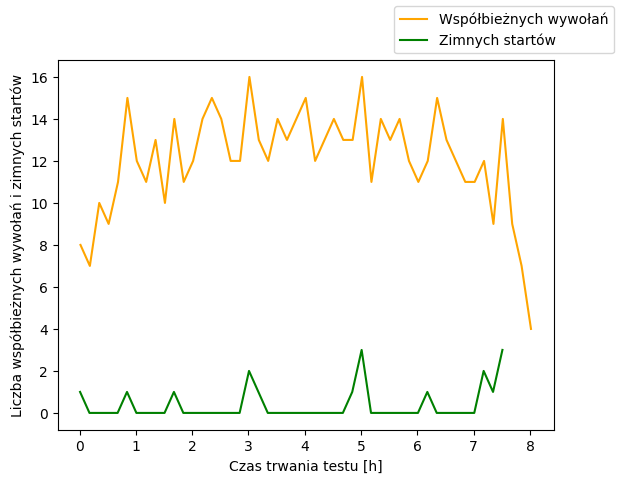

In [17]:

# TODO: zestawić czas trwania żądania z liczbą (jednoczesnych) wywołań lambd

fig, ax = start_plot()

logs_resampled = logs.resample('10T').median(numeric_only=True)

# ax.plot(human_delta(logs_resampled.index), logs_resampled['duration'], label="Czas wywołania", color='red')
# ax2 = ax.twinx()
ax.plot(human_delta(resampled_concurrent.index), resampled_concurrent['concurrentExecutions'], label="Współbieżnych wywołań", color='orange')
ax.set_ylabel('Liczba współbieżnych wywołań i zimnych startów')
ax.plot(human_delta(cold_starts.index), cold_starts['duration'], color='green', label='Zimnych startów')
# ax.set_ylabel('Mediana czasu wykonania funkcji [ms]')
# ax.set_title('Serverless')
fig.legend()


# CZAS WYKONANIA FUNKCJI! A nie czas odpowiedzi, API Gateway dodaje +100 latency, co najmniej.
# Byśmy musieli mieć raw data from EC2 żeby to porównywać load testowo, a nie mamy.
# No możemy niby mieć...

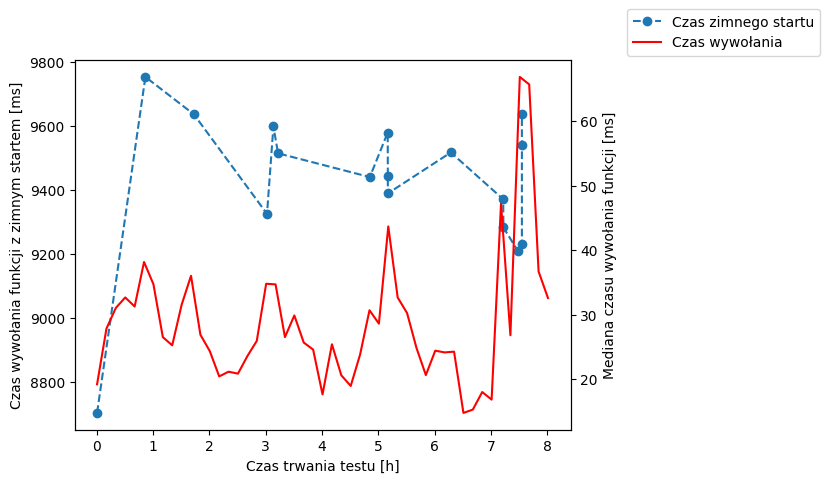

In [11]:
fig, ax = start_plot()

only_cold_start = logs[logs['initDuration'] > 0]

ax.plot(human_delta(only_cold_start.index), only_cold_start['duration'], label="Czas zimnego startu", marker='o', linestyle='--')
ax2 = ax.twinx()
ax2.plot(human_delta(logs_resampled.index), logs_resampled['duration'], label="Czas wywołania", color='red')
ax.set_ylabel("Czas wywołania funkcji z zimnym startem [ms]")
ax2.set_ylabel("Mediana czasu wywołania funkcji [ms]")
fig.legend(bbox_to_anchor=(0.8, 0, 0.5, 1))



2022-12-27 08:44:00


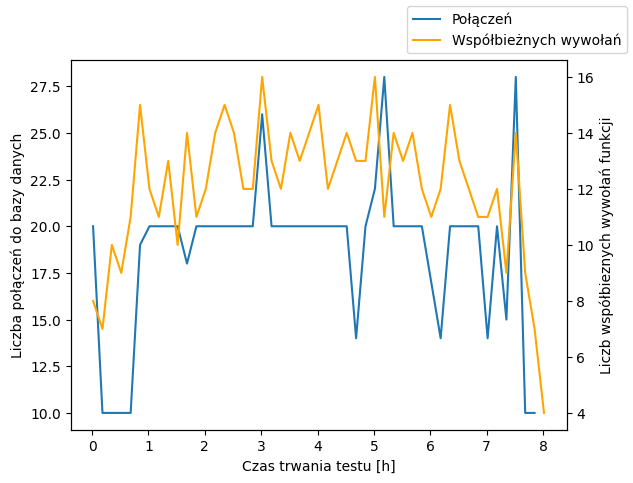

In [12]:
aurora_connections = load_cloudwatch(f"{prefix}/aurora/connections.csv")
aurora_connections = aurora_connections.resample('10T').sum(numeric_only=True)
aurora_connections = aurora_connections[aurora_connections.index < test_duration]

fig, ax = start_plot()
ax.plot(human_delta(aurora_connections.index), aurora_connections['databaseConnections'], label="Połączeń")
ax2 = ax.twinx()
ax2.set_ylabel('Liczb współbieznych wywołań funkcji')
ax2.plot(human_delta(resampled_concurrent.index), resampled_concurrent['concurrentExecutions'], color='orange', label="Współbieżnych wywołań")
ax.set_ylabel('Liczba połączeń do bazy danych')
fig.legend()


2022-12-27 08:44:00
2022-12-27 08:44:00


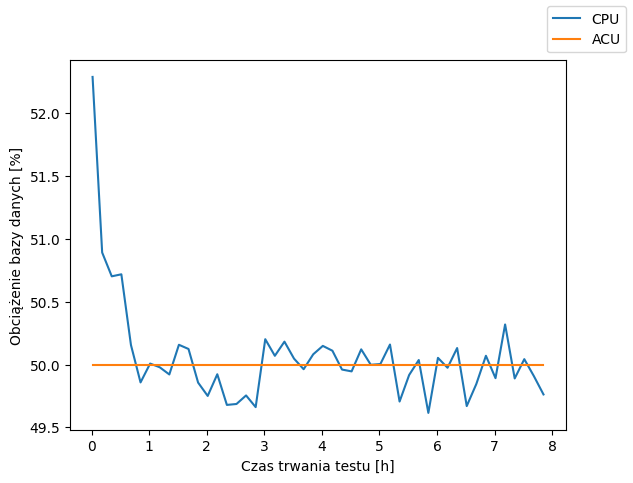

In [13]:
aurora_cpu = load_cloudwatch(f"{prefix}/aurora/cpu.csv")
aurora_cpu = aurora_cpu.resample('10T').mean(numeric_only=True)
aurora_cpu = aurora_cpu[aurora_cpu.index < test_duration]

aurora_acu = load_cloudwatch(f"{prefix}/aurora/acu.csv")
aurora_acu = aurora_acu.resample('10T').mean(numeric_only=True)
aurora_acu = aurora_acu[aurora_acu.index < test_duration]


fig, ax = start_plot()
ax.plot(human_delta(aurora_cpu.index), aurora_cpu['cpu'], label='CPU')
ax.plot(human_delta(aurora_acu.index), aurora_acu['acu'], label='ACU')
ax.set_ylabel('Obciążenie bazy danych [%]')
fig.legend()
